# Separate events in predictions

01.09.2022

Uso questo script per separare gli eventi nelle predictions, così da poter poi calcolare le metrics sulla instance segmentation.

Due idee:
- prima separare le classi e poi gli eventi
- sommare le preds delle classi, separare gli eventi e poi separare le classi

Una volta fatto, includere le funzioni in uno script normale di Python (.py) e usarle per la validation dei modelli (magari anche durante il training). A quel punto si potrà eliminare questo notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage.io import imsave

import cc3d
from scipy import ndimage as ndi

from dataset_tools import load_annotations_ids
from preds_processing_tools import (get_discrete_cmap,
                                    get_argmax_segmentation_otsu,
                                    get_separated_events
                                   )
from dataset_tools import detect_spark_peaks

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Functions and global parameters

In [4]:
# configure Napari cmap
cmap = get_discrete_cmap(name='gray', lut=16)

# global parameters
PIXEL_SIZE = 0.2 # 1 pixel = 0.2 um x 0.2 um
global MIN_DIST_XY
MIN_DIST_XY = round(1.8 / PIXEL_SIZE) # min distance in space between sparks
TIME_FRAME = 6.8 # 1 frame = 6.8 ms
global MIN_DIST_T
MIN_DIST_T = round(20 / TIME_FRAME) # min distance in time between sparks

# parameters for puffs and waves CCs detection
connectivity = 26

# define minimal width of a detected wave (15 um)
global WAVE_MIN_WIDTH
WAVE_MIN_WIDTH = round(15/PIXEL_SIZE)

# parameters for spark peaks detection
radius = math.ceil(MIN_DIST_XY/2)
y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
disk = x**2+y**2 <= radius**2
connectivity_mask = np.stack([disk]*(MIN_DIST_T), axis=0)

sigma = 3
ignore_frames_loss = 6 # frames ignored by loss fct during training

# maximal gap between two predicted puffs or waves that belong together
max_gap = 2 # i.e., 2 empty frames

In [5]:
classes = ['sparks', 'puffs', 'waves']

class_to_nb = {'sparks': 1,
               'puffs': 3,
               'waves': 2,
               'ignore_rois': 4
              }

## Load predictions

Load predictions from files generated when running the test function during training.

They are saved in `runs\<training_name>\predictions` and the filename template is `<training_name>_<movie_id>_<preds class/xs/ys/...>.tif`.

The epoch is not explicitly mentionned, but it depends on the last epoch of the last model that has been run.

In [6]:
# assuming these are the movie IDs whose predictions are available...
movie_ids = ["05","10","15","20","25","32","34","40","45"]

### Select training name to load

In [7]:
training_name = 'TEMP_new_annotated_peaks_physio'

### Configure input & output directory

In [8]:
data_dir = os.path.join("runs", training_name, "predictions")
out_dir = os.path.join("trainings_validation", training_name, "separated_events")

### Load movies, annotations and predictions

In [9]:
### Load movies
xs_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_xs.tif") for movie_id in movie_ids}
xs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in xs_filenames.items()}

### Load annotations
# Annotations used during training (from predictions folder)

ys_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_ys.tif") for movie_id in movie_ids}
ys = {movie_id: np.asarray(imageio.volread(f)).astype('int') for movie_id, f in ys_filenames.items()}

### Load annotated event instances
dataset_dir =  os.path.join("..", "data", "sparks_dataset")
annotated_events = load_annotations_ids(data_folder=dataset_dir,
                                        ids=movie_ids,
                                        mask_names="event_label"
                                        )

### Load predictions
# Predictions created from selected model

sparks_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(data_dir, training_name+"_"+movie_id+"_waves.tif") for movie_id in movie_ids}

sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

#### Ensure that annotated event IDs are consecutive

Re-organise `annotated_events` dict to be indexed by `sample_id` and `event_type`...

In [10]:
def renumber_labelled_mask(labelled_mask):
    '''
    labelled_mask: numpy array with labelled events (positive integers)
    
    return mask where such events are numbered in a consecutive way
    '''
    # renumber labelled events
    old_labels = np.unique(labelled_mask)
    new_mask = np.zeros_like(labelled_mask)
    
    for new_id, old_id in enumerate(old_labels):
        new_mask[labelled_mask==old_id] = new_id
        
    # check that the number of events hasn't changed
    new_labels = np.unique(new_mask)
    assert len(old_labels)-1 == np.max(new_labels), \
        f"New labels are wrong: {new_labels}"
    
    return new_mask

In [11]:
for sample_id in movie_ids:
    # temporary dict to store re-organised annotated events
    temp_events = {}
    
    sample_ys = ys[sample_id] # array with values in {0,1,2,3,4}
    sample_events = annotated_events[sample_id] # array with int values
    
    for event_type in classes+['ignore_rois']:
        # get binary annotated mask of current event type
        class_mask = sample_ys == class_to_nb[event_type]
        
        # get separated events belonging to this class
        event_mask = np.where(class_mask, sample_events, 0)
        
        # renumber annotated events
        temp_events[event_type] = renumber_labelled_mask(labelled_mask=event_mask)
        
    # save temporary event dict in annotated event dict
    annotated_events[sample_id] = temp_events

### TEMP: Get duration of shortest annotated puff

IDEA: per il momento uso questo come bound inferiore per i puffs detettati, più in là lo cambierò con un valore più adatto

In [12]:
global PUFF_MIN_T
PUFF_MIN_T = 9999

for sample_id in movie_ids:
    puffs_events = annotated_events[sample_id]['puffs']
    if puffs_events.any():
        puffs_slices = ndi.measurements.find_objects(puffs_events)
        puffs_durations = [puff_slice[0].stop - puff_slice[0].start
                           for puff_slice in puffs_slices]
        shortest_puff = np.min(puffs_durations)

        if shortest_puff < PUFF_MIN_T:
            PUFF_MIN_T = shortest_puff

In [13]:
print("Shortest annotated puff duration:", PUFF_MIN_T)

Shortest annotated puff duration: 5


### TEMP: Get duration and width of shortest annotated spark

IDEA: per il momento uso questo come bound inferiore per i sparks detettati, più in là lo cambierò con un valore più adatto

In [14]:
global SPARK_MIN_T
SPARK_MIN_T = 9999
global SPARK_MIN_WIDTH
SPARK_MIN_WIDTH = 9999

for sample_id in movie_ids:
    sparks_events = annotated_events[sample_id]['sparks']
    if sparks_events.any():
        sparks_slices = ndi.measurements.find_objects(sparks_events)
        sparks_durations = [spark_slice[0].stop - spark_slice[0].start
                           for spark_slice in sparks_slices]
        shortest_spark = np.min(sparks_durations)
        sparks_widths = [min(spark_slice[1].stop - spark_slice[1].start,
                             spark_slice[2].stop - spark_slice[2].start)
                           for spark_slice in sparks_slices]
        tightest_spark = np.min(sparks_widths)

        if shortest_spark < SPARK_MIN_T:
            SPARK_MIN_T = shortest_spark

        if tightest_spark < SPARK_MIN_WIDTH:
            SPARK_MIN_WIDTH = tightest_spark

In [15]:
print("Shortest annotated spark duration:", SPARK_MIN_T)
print("Smallest annotated spark width:", SPARK_MIN_WIDTH)

Shortest annotated spark duration: 3
Smallest annotated spark width: 3


#### Compute ignore mask for all movies

In [16]:
ignore_index = 4
ignore_masks = {movie_id: movie_ys==ignore_index for movie_id, movie_ys in ys.items()}

# Separate events in all movies

In [17]:
# Dict indexed by movie IDs
separated_events = {}
segmented_preds = {}
sparks_loc = {}

### SEPARATE EVENTS USING OTSU THRESHOLD

In [18]:
for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    
    sample = {'xs' : xs[sample_id],
              'ys' : ys[sample_id]}

    preds = {'sparks' : sparks[sample_id],
             'puffs' : puffs[sample_id],
             'waves' : waves[sample_id],
             'background' : 1-sparks[sample_id]-puffs[sample_id]-waves[sample_id]}

    #### Get argmax segmentation
    # Using Otsu threshold on summed predictions
    argmax_preds, segmented_preds[sample_id] = get_argmax_segmentation_otsu(preds=preds,
                                                   get_classes=True,
                                                   debug=True)

    #### Separate events in predictions
    separated_events[sample_id], sparks_loc[sample_id] = get_separated_events(argmax_preds=argmax_preds,
                                                                            movie=sample['xs'],
                                                                            sigma=sigma,
                                                                            connectivity=connectivity,
                                                                            connectivity_mask=connectivity_mask,
                                                                            return_sparks_loc=True,
                                                                            debug=True)

Processing movie 05 ...
	Events detection threshold: 0.77835023
	Number of sparks detected by nonmaxima suppression: 147
Processing movie 10 ...
	Events detection threshold: 0.77862483
	Number of sparks detected by nonmaxima suppression: 38
	Not all sparks were labelled, computing missing events...
	Number of sparks before correction: 38
	Number of sparks after correction: 41
Processing movie 15 ...
	Events detection threshold: 0.781229
	Number of sparks detected by nonmaxima suppression: 21
Processing movie 20 ...
	Events detection threshold: 0.78007257
	Number of sparks detected by nonmaxima suppression: 94
	Not all sparks were labelled, computing missing events...
	Number of sparks before correction: 94
	Number of sparks after correction: 96
Processing movie 25 ...
	Events detection threshold: 0.7764422
	Number of sparks detected by nonmaxima suppression: 100
	Not all sparks were labelled, computing missing events...
	Number of sparks before correction: 100
	Number of sparks after c

### TEMP: SEPARATE EVENTS USING RAW ARGMAX

In [19]:
#from preds_processing_tools import get_argmax_segmented_output

#for sample_id in movie_ids:
#    print("Processing movie", sample_id, "...")
    
#    sample = {'xs' : xs[sample_id],
#              'ys' : ys[sample_id]}

#    preds = {'sparks' : sparks[sample_id],
#             'puffs' : puffs[sample_id],
#             'waves' : waves[sample_id],
#             'background' : 1-sparks[sample_id]-puffs[sample_id]-waves[sample_id]}

#    #### Get argmax segmentation (THIS IS DIFFERENT)
#    # Using Otsu threshold on summed predictions
#    preds_array = [preds['background'],
#                   preds['sparks'],
#                   preds['waves'],
#                   preds['puffs']]
    
#    argmax_preds, segmented_preds[sample_id] = get_argmax_segmented_output(preds=preds_array,
#                                                                           get_classes=True)

#    #### Separate events in predictions
#    separated_events[sample_id], sparks_loc[sample_id] = get_separated_events(argmax_preds=argmax_preds,
#                                                                            movie=sample['xs'],
#                                                                            sigma=sigma,
#                                                                            connectivity=connectivity,
#                                                                            connectivity_mask=connectivity_mask,
#                                                                            return_sparks_loc=True,
#                                                                            debug=True)

### TEMP (MIDTERM): uso questo codice per salvare un'immagine delle preds con Napari

## Events postprocessing

- remove events that intersect ignore regions (add them to "ignored" dict) OK
- remove events in slices ignored by loss function
- remove sparks that are shorter than 2 slices OK
- merge puffs that are close enough in time (!!! or try to not spearate them before !!!) OK
- remove puffs and waves that are less than ? in size (ask Miguel) OK --> still need to ask values

## Remove artifacts

Remove small predicted events and merge events belonging together

In [20]:
def merge_labels(labelled_mask, max_gap):
    '''
    merge labels in input mask, if their distance in time is 
    smaller than the max gap
    '''
    # only run code if labelled_mask is non-empty
    
    if labelled_mask.any():
        # dilate annotations along time
        struct = np.zeros((max_gap+1,3,3))
        struct[:,1,1] = 1
        dilated_labels_t = ndi.binary_dilation(labelled_mask, structure=struct)

        # count if number of waves has decreased
        conn = 26
        merged_labels, n_merged_labels = cc3d.connected_components(dilated_labels_t,
                                                                   connectivity=conn,
                                                                   return_N=True)
        
        # if some labels have merged, re-label mask accordingly
        if n_merged_labels < len(np.unique(labelled_mask))-1:
            print("Merging events since their gap distance is below", max_gap)
            print("Labels before merging:", np.unique(labelled_mask))

            merged_labelled_mask = np.where(labelled_mask, merged_labels, 0)
            print("Labels after merging:", np.unique(merged_labelled_mask))
            return merged_labelled_mask
        else:
            return labelled_mask
        
    else:
        return labelled_mask

In [21]:
old_nb_ys = {}
old_nb_preds = {}

for sample_id in movie_ids:
    print(f"Movie n.{sample_id}:")
    # get number of events for each class
    old_nb_ys[sample_id] = {}
    old_nb_preds[sample_id] = {}
    for event_type in classes:
        old_nb_ys[sample_id][event_type] = np.max(annotated_events[sample_id][event_type])
        old_nb_preds[sample_id][event_type] = np.max(separated_events[sample_id][event_type])

    old_nb_ys[sample_id]['tot'] =  sum(old_nb_ys[sample_id].values())
    old_nb_preds[sample_id]['tot'] =  sum(old_nb_preds[sample_id].values())

    print("Annotated events:", old_nb_ys[sample_id])
    print("Predicted events:", old_nb_preds[sample_id])
    print()

Movie n.05:
Annotated events: {'sparks': 71, 'puffs': 26, 'waves': 0, 'tot': 97}
Predicted events: {'sparks': 147, 'puffs': 56, 'waves': 3, 'tot': 206}

Movie n.10:
Annotated events: {'sparks': 22, 'puffs': 7, 'waves': 0, 'tot': 29}
Predicted events: {'sparks': 41, 'puffs': 18, 'waves': 0, 'tot': 59}

Movie n.15:
Annotated events: {'sparks': 42, 'puffs': 12, 'waves': 0, 'tot': 54}
Predicted events: {'sparks': 21, 'puffs': 10, 'waves': 0, 'tot': 31}

Movie n.20:
Annotated events: {'sparks': 70, 'puffs': 17, 'waves': 0, 'tot': 87}
Predicted events: {'sparks': 96, 'puffs': 21, 'waves': 0, 'tot': 117}

Movie n.25:
Annotated events: {'sparks': 31, 'puffs': 1, 'waves': 0, 'tot': 32}
Predicted events: {'sparks': 102, 'puffs': 6, 'waves': 1, 'tot': 109}

Movie n.32:
Annotated events: {'sparks': 7, 'puffs': 2, 'waves': 0, 'tot': 9}
Predicted events: {'sparks': 8, 'puffs': 20, 'waves': 3, 'tot': 31}

Movie n.34:
Annotated events: {'sparks': 16, 'puffs': 3, 'waves': 6, 'tot': 25}
Predicted events

### WAVES

In [22]:
# remove small events from separated events masks
for sample_id in movie_ids:
    print(f"Movie n.{sample_id}:")
    separated_waves = separated_events[sample_id]['waves']

    # merge waves that belong together
    separated_waves = merge_labels(labelled_mask=separated_waves,
                                   max_gap=max_gap)

    # remove small waves
    waves_ids = list(np.unique(separated_waves))
    waves_ids.remove(0)

    for idx in waves_ids:
        wave_roi = separated_waves==idx
        wave_slices = ndi.measurements.find_objects(wave_roi)[0]
        wave_length = wave_slices[-1].stop - wave_slices[-1].start

        # if wave is too short, remove it from predictions
        if wave_length < WAVE_MIN_WIDTH:
            print(f"Removing wave labelled with {idx} (too small)")
            separated_waves = np.where(wave_roi, 0, separated_waves)

    separated_events[sample_id]['waves'] = separated_waves
    
    # update segmented predicted mask accordingly
    old_wave_mask = segmented_preds[sample_id]==2
    removed_waves = np.logical_xor(old_wave_mask, separated_waves.astype(bool))
    segmented_preds[sample_id] = np.where(removed_waves, 0, segmented_preds[sample_id])
    print()

Movie n.05:
Removing wave labelled with 1 (too small)
Removing wave labelled with 2 (too small)
Removing wave labelled with 3 (too small)

Movie n.10:

Movie n.15:

Movie n.20:

Movie n.25:
Removing wave labelled with 1 (too small)

Movie n.32:
Merging events since their gap distance is below 2
Labels before merging: [0 1 2 3]
Labels after merging: [0 1 2]
Removing wave labelled with 1 (too small)
Removing wave labelled with 2 (too small)

Movie n.34:
Removing wave labelled with 4 (too small)
Removing wave labelled with 5 (too small)
Removing wave labelled with 6 (too small)
Removing wave labelled with 7 (too small)

Movie n.40:
Removing wave labelled with 1 (too small)
Removing wave labelled with 3 (too small)

Movie n.45:
Removing wave labelled with 1 (too small)
Removing wave labelled with 2 (too small)
Removing wave labelled with 3 (too small)
Removing wave labelled with 5 (too small)
Removing wave labelled with 6 (too small)
Removing wave labelled with 7 (too small)
Removing wave 

### PUFFS

In [23]:
# remove small events from separated events masks
for sample_id in movie_ids:
    print(f"Movie n.{sample_id}:")
    separated_puffs = separated_events[sample_id]['puffs']

    # merge puffs that belong together
    separated_puffs = merge_labels(labelled_mask=separated_puffs,
                                   max_gap=max_gap)

    # remove small puffs
    puffs_ids = list(np.unique(separated_puffs))
    puffs_ids.remove(0)

    for idx in puffs_ids:
        puff_roi = separated_puffs==idx
        puff_slices = ndi.measurements.find_objects(puff_roi)[0]
        puff_duration = puff_slices[0].stop - puff_slices[0].start

        # if puff is too short, remove it from predictions
        if puff_duration < PUFF_MIN_T:
            print(f"Removing puff labelled with {idx} (too short)")
            separated_puffs = np.where(puff_roi, 0, separated_puffs)

    separated_events[sample_id]['puffs'] = separated_puffs
    
    # update segmented predicted mask accordingly
    old_puff_mask = segmented_preds[sample_id]==3
    removed_puffs = np.logical_xor(old_puff_mask, separated_puffs.astype(bool))
    segmented_preds[sample_id] = np.where(removed_puffs, 0, segmented_preds[sample_id])
    print()

Movie n.05:
Merging events since their gap distance is below 2
Labels before merging: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Labels after merging: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
Removing puff labelled with 4 (too short)
Removing puff labelled with 10 (too short)
Removing puff labelled with 14 (too short)
Removing puff labelled with 17 (too short)
Removing puff labelled with 19 (too short)
Removing puff labelled with 20 (too short)
Removing puff labelled with 22 (too short)
Removing puff labelled with 31 (too short)
Removing puff labelled with 33 (too short)
Removing puff labelled with 34 (too short)
Removing puff labelled with 36 (too short)
Removing puff labelled with 44 (too short)
Removing puff labelled with 48

### SPARKS

In [24]:
# remove small events from separated events masks
for sample_id in movie_ids:
    print(f"Movie n.{sample_id}:")
    separated_sparks = separated_events[sample_id]['sparks']

    # remove small sparks
    sparks_ids = list(np.unique(separated_sparks))
    sparks_ids.remove(0)

    for idx in sparks_ids:
        spark_roi = separated_sparks==idx
        spark_slices = ndi.measurements.find_objects(spark_roi)[0]
        spark_duration = spark_slices[0].stop - spark_slices[0].start
        spark_width = min(spark_slices[1].stop - spark_slices[1].start,
                          spark_slices[2].stop - spark_slices[2].start)

        # if spark is too short, remove it from predictions
        if spark_duration < SPARK_MIN_T:
            print(f"Removing spark labelled with {idx} (too short)")
            separated_sparks = np.where(spark_roi, 0, separated_sparks)

        # if spark is too small, remove it from predictions
        if spark_width < SPARK_MIN_WIDTH:
            print(f"Removing spark labelled with {idx} (too small)")
            separated_sparks = np.where(spark_roi, 0, separated_sparks)

    separated_events[sample_id]['sparks'] = separated_sparks

    # update segmented predicted mask accordingly
    old_spark_mask = segmented_preds[sample_id]==1
    removed_sparks = np.logical_xor(old_spark_mask, separated_sparks.astype(bool))
    segmented_preds[sample_id] = np.where(removed_sparks, 0, segmented_preds[sample_id])

    # remove spark peak locations of sparks that have been removed

    corrected_loc = []
    for t,y,x in sparks_loc[sample_id]:
        if separated_events[sample_id]['sparks'][t,y,x] != 0:
            corrected_loc.append([t,y,x])     

    sparks_loc[sample_id] = corrected_loc
    print()

Movie n.05:
Removing spark labelled with 57 (too short)
Removing spark labelled with 57 (too small)
Removing spark labelled with 72 (too short)
Removing spark labelled with 72 (too small)
Removing spark labelled with 92 (too small)
Removing spark labelled with 104 (too short)
Removing spark labelled with 104 (too small)
Removing spark labelled with 144 (too short)
Removing spark labelled with 144 (too small)

Movie n.10:
Removing spark labelled with 10 (too small)
Removing spark labelled with 33 (too small)
Removing spark labelled with 34 (too small)
Removing spark labelled with 40 (too small)
Removing spark labelled with 41 (too short)
Removing spark labelled with 41 (too small)

Movie n.15:
Removing spark labelled with 8 (too small)

Movie n.20:
Removing spark labelled with 24 (too short)
Removing spark labelled with 24 (too small)
Removing spark labelled with 95 (too small)
Removing spark labelled with 96 (too small)

Movie n.25:
Removing spark labelled with 3 (too short)
Removing s

### TEMP (MIDTERM): uso questo codice per salvare immagini di esempi di frames delle preds con Napari

In [47]:
sample_id = '05'

In [52]:
preds_segmentation = segmented_preds[sample_id]
labels_segmentation = ys[sample_id]

In [49]:
movie = xs[sample_id]

#### compute annotations contour, for Napari visualisation

In [41]:
from scipy.ndimage.morphology import binary_dilation, binary_erosion

In [53]:
# need to dilate and erode each class separately

contour_val = 2

# dilate only along x and y
struct = np.zeros((1,1+contour_val,1+contour_val))
struct[0,1,:] = 1
struct[0,:,1] = 1

labels_contour = np.zeros_like(labels_segmentation)

for class_nb in range(1,5):
    class_ys = labels_segmentation == class_nb
    class_dilated = binary_dilation(class_ys, structure=struct)
    class_eroded = binary_erosion(class_ys, structure=struct)
    class_contour = np.where(np.logical_not(class_eroded.astype(bool)),
                             class_dilated,
                             0
                            )
    labels_contour += class_nb*class_contour.astype(labels_contour.dtype)

#### visualise results with Napari

In [31]:
from matplotlib import cm
import vispy.color

def get_discrete_cmap(name='viridis', lut=16):
    # create original cmap
    segmented_cmap = cm.get_cmap(name=name, lut=16)

    # get colors
    colors = segmented_cmap(np.arange(0,segmented_cmap.N))
    # get new discrete cmap
    cmap = vispy.color.Colormap(colors, interpolation='zero')

    return cmap

cmap = get_discrete_cmap(name='gray', lut=16)

In [32]:
no_color = [0,0,0,0]
green_spark = [178/255, 255/255, 102/255, 1]
red_puff = [255/255, 102/255, 102/255, 1]
purple_wave = [178/255, 102/255, 255/255, 1]
grey_ignore = [224/255, 224/255, 224/255, 1]
black = [1,1,1,1]

labels_cmap = {
    0: no_color,
    1: green_spark,
    2: purple_wave,
    3: red_puff,
    4: grey_ignore,
    5: black
}

In [33]:
viewer = napari.Viewer()
viewer.theme = 'light'

In [50]:
viewer.add_image(movie, 
                 name='movie', 
                 colormap=('colors',cmap)
                )

<Image layer 'movie [1]' at 0x22da2d0a3d0>

In [54]:
preds = viewer.add_labels(preds_segmentation,
                          name='class preds',
                          color=labels_cmap,
                          opacity=.3
                         )

labels = viewer.add_labels(labels_contour,
                           name='class annotations',
                           color=labels_cmap,
                           opacity=1
                          )

In [45]:
screenshot = viewer.screenshot()
#viewer.add_image(screenshot, rgb=True, name='screenshot')

In [46]:
frame_nb = 655

out_dir = f"C:/Users/dotti/OneDrive - Universitaet Bern/midterm/figures/unet_predictions_figures/movie_{sample_id}_qualitative_results"
out_f = os.path.join(out_dir, f"movie_{sample_id}_segmentation_comparison_frame_{frame_nb}.png")

imsave(out_f, screenshot)

### Renumber ys and preds, so that each event has a unique ID

In [25]:
# renumber predictions

In [26]:
nb_ys = old_nb_ys
nb_preds = {}

for sample_id in movie_ids:
    print(f"Movie n.{sample_id}:")
    for event_type in classes:
        separated_events[sample_id][event_type] = renumber_labelled_mask(labelled_mask=separated_events[sample_id][event_type])

    # udpate dict with number of predicted events
    # get number of events for each class
    nb_preds[sample_id] = {}
    for event_type in classes:
        nb_preds[sample_id][event_type] = np.max(separated_events[sample_id][event_type])

    nb_preds[sample_id]['tot'] =  sum(nb_preds[sample_id].values())

    print(f"Number of annotated events per class: {nb_ys[sample_id]}")
    print(f"Number of predicted events per class: {nb_preds[sample_id]} (used to be {old_nb_preds[sample_id]})")
    print()

    # renumber each puff and wave, so that event has a unique ID
    ys_puffs = annotated_events[sample_id]['puffs']
    ys_waves = annotated_events[sample_id]['waves']
    ys_puffs[ys_puffs != 0] += nb_ys[sample_id]['sparks']
    ys_waves[ys_waves != 0] += (nb_ys[sample_id]['sparks']+nb_ys[sample_id]['puffs'])

    preds_puffs = separated_events[sample_id]['puffs']
    preds_waves = separated_events[sample_id]['waves']
    preds_puffs[preds_puffs != 0] += nb_preds[sample_id]['sparks']
    preds_waves[preds_waves != 0] += (nb_preds[sample_id]['sparks']+nb_preds[sample_id]['puffs'])
    
    if nb_ys[sample_id]['sparks'] != 0:
        print("annotated sparks range:", 1, "to", nb_ys[sample_id]['sparks'])
    else:
        print("annotated sparks range: 0 to 0")
    if nb_ys[sample_id]['puffs'] != 0:
        print("annotated puffs range:", np.min(ys_puffs[ys_puffs != 0]), "to", np.max(ys_puffs))
    else:
        print("annotated puffs range: 0 to 0")
    if nb_ys[sample_id]['waves'] != 0:
        print("annotated waves range:", np.min(ys_waves[ys_waves != 0]), "to", np.max(ys_waves))
    else:
        print("annotated waves range: 0 to 0")
    print()
    if nb_preds[sample_id]['sparks'] != 0:
        print("predicted sparks range:", 1, "to", nb_preds[sample_id]['sparks'])
    else:
        print("predicted sparks range: 0 to 0")
    if nb_preds[sample_id]['puffs'] != 0:
        print("predicted puffs range:", np.min(preds_puffs[preds_puffs != 0]), "to", np.max(preds_puffs))
    else:
        print("predicted puffs range: 0 to 0")
    if nb_preds[sample_id]['waves'] != 0:
        print("predicted waves range:", np.min(preds_waves[preds_waves != 0]), "to", np.max(preds_waves))
    else:
        print("predicted waves range: 0 to 0")
    print()

Movie n.05:
Number of annotated events per class: {'sparks': 71, 'puffs': 26, 'waves': 0, 'tot': 97}
Number of predicted events per class: {'sparks': 142, 'puffs': 42, 'waves': 0, 'tot': 184} (used to be {'sparks': 147, 'puffs': 56, 'waves': 3, 'tot': 206})

annotated sparks range: 1 to 71
annotated puffs range: 72 to 97
annotated waves range: 0 to 0

predicted sparks range: 1 to 142
predicted puffs range: 143 to 184
predicted waves range: 0 to 0

Movie n.10:
Number of annotated events per class: {'sparks': 22, 'puffs': 7, 'waves': 0, 'tot': 29}
Number of predicted events per class: {'sparks': 36, 'puffs': 12, 'waves': 0, 'tot': 48} (used to be {'sparks': 41, 'puffs': 18, 'waves': 0, 'tot': 59})

annotated sparks range: 1 to 22
annotated puffs range: 23 to 29
annotated waves range: 0 to 0

predicted sparks range: 1 to 36
predicted puffs range: 37 to 48
predicted waves range: 0 to 0

Movie n.15:
Number of annotated events per class: {'sparks': 42, 'puffs': 12, 'waves': 0, 'tot': 54}
Num

## Compute annotation-pred matches

For each pair (annotation, pred) compute their _score_ (IoU or IoMin) and then match annotations with predictions

Sparks are processed in a different way, by computing their peak distances

In [27]:
def compute_iou(ys_roi, preds_roi, ignore_mask=None):
    '''
    Compute IoU for given single annotated and predicted events.
    ys_roi :            annotated event ROI
    preds_roi :         predicted event ROI
    ignore_mask :       mask that is ignored by loss function during training
    '''
    # define mask where pixels aren't ignored by loss function
    if ignore_mask is not None:
        compute_mask = np.logical_not(ignore_mask)
        preds_roi_real = np.logical_and(preds_roi, compute_mask)
    else:
        preds_roi_real = preds_roi

    intersection = np.logical_and(ys_roi, preds_roi_real)
    union = np.logical_or(ys_roi, preds_roi_real)
    iou = np.count_nonzero(intersection) / np.count_nonzero(union)
    return iou

def compute_inter_min(ys_roi, preds_roi, ignore_mask=None):
    '''
    Compute intersection over minimum area for given single annotated and predicted events.
    ys_roi :            annotated event ROI
    preds_roi :         predicted event ROI
    ignore_mask :       mask that is ignored by loss function during training
    '''
    # define mask where pixels aren't ignored by loss function
    if ignore_mask is not None:
        compute_mask = np.logical_not(ignore_mask)
        preds_roi_real = np.logical_and(preds_roi, compute_mask)
    else:
        preds_roi_real = preds_roi

    intersection = np.logical_and(ys_roi, preds_roi_real)
    ys_area = np.count_nonzero(ys_roi)
    preds_area = np.count_nonzero(preds_roi_real)
    
    if preds_area > 0:
        iomin = np.count_nonzero(intersection) / min(preds_area, ys_area)
    else:
        iomin = 0
    return iomin

### Compute pairwise scores...

In [28]:
iou_scores = {}
iomin_scores = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # get score matrix for the two types of score: IoU and IoMin
    iou_scores[sample_id] = np.zeros((nb_ys[sample_id]['tot'], nb_preds[sample_id]['tot']))
    iomin_scores[sample_id] = np.zeros((nb_ys[sample_id]['tot'], nb_preds[sample_id]['tot']))

    # get ignore regions
    ignore_mask = ignore_masks[sample_id]

    # get matrices with all separated annotated and predicted events summed
    ys_all_events = sum(annotated_events[sample_id].values())
    preds_all_events = sum(separated_events[sample_id].values())

    # compute pairwise values 
    for pred_id in range(1,nb_preds[sample_id]['tot']+1):
        preds_roi = preds_all_events==pred_id
        # check that the ROI is not empty
        #assert preds_roi.any(), f"the predicted ROI n.{pred_id} is empty!"

        # check if ROI intersect at least one annotated event
        if np.count_nonzero(np.logical_and(ys_all_events, preds_roi)) != 0:

            for ys_id in range(1,nb_ys[sample_id]['tot']+1):
                ys_roi = ys_all_events==ys_id
                # check that the ROI is not empty
                #assert ys_roi.any(), f"the annotated ROI n.{ys_roi} is empty!"

                # check if predicted and annotated ROIs intersect
                if np.count_nonzero(np.logical_and(ys_roi, preds_roi)) != 0:

                    # compute scores
                    iou_scores[sample_id][ys_id-1,pred_id-1] = compute_iou(ys_roi=ys_roi,
                                                            preds_roi=preds_roi,
                                                            ignore_mask=ignore_mask)

                    iomin_scores[sample_id][ys_id-1,pred_id-1] = compute_inter_min(ys_roi=ys_roi,
                                                                    preds_roi=preds_roi,
                                                                    ignore_mask=ignore_mask)

# assertions take ~45s to be computed...

Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...


### Compute correspondences and get confusion matrix

In [29]:
# ID used for preds that are matched with an ignored event
matched_ignore_id = 9999

In [30]:
iou_t = 0.3
iomin_t = 0.5

#### Intersection over Union

In [31]:
iou_confusion_matrix = {}
iou_matched_events = {}
iou_ignored_preds = {}

print("Compute event correspondences:")

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # dict indexed by predicted event indices, s.t. each entry is the 
    # list of annotated event ids that match the predicted event
    iou_matched_events[sample_id] = {}

    # confusion matrix cols and rows indices: {background, sparks, puffs, waves}
    iou_confusion_matrix[sample_id] = np.zeros((4,4))

    # count number of predicted events that are ignored
    iou_ignored_preds[sample_id] = 0

    for pred_class in classes:
        pred_class_id = class_to_nb[pred_class]
        # get ids of pred events in given class
        pred_ids = list(np.unique(separated_events[sample_id][pred_class]))
        pred_ids.remove(0)

        # get ids of y events in same class
        y_ids = set(np.unique(annotated_events[sample_id][pred_class]))
        y_ids.remove(0)

        # get name of different classes
        other_classes = classes[:]
        other_classes.remove(pred_class)

        # get ignore regions
        ignore_mask = ignore_masks[sample_id]

        for pred_id in pred_ids:
            # get set of y_ids that are matched with pred_id (score > t):
            iou_matched_events[sample_id][pred_id] = np.where(iou_scores[sample_id][:,pred_id-1] >= iou_t)[0] + 1
            iou_matched_events[sample_id][pred_id] = set(iou_matched_events[sample_id][pred_id])

            # if at least one matched event is in same class, increase confusion matrix
            if (iou_matched_events[sample_id][pred_id] & y_ids): 
                iou_confusion_matrix[sample_id][pred_class_id,pred_class_id] += 1

            # else, if no y event is matched with this pred, check if it is ignored
            elif not iou_matched_events[sample_id][pred_id]:

                pred_roi = separated_events[sample_id][pred_class] == pred_id
                pred_roi_size = np.count_nonzero(pred_roi)

                ignored_roi = np.logical_and(pred_roi, ignore_mask)
                ignored_roi_size = np.count_nonzero(ignored_roi)

                overlap = ignored_roi_size/pred_roi_size

                # if the overlap is not large enough, count pred as FP
                if overlap < iou_t:
                    iou_confusion_matrix[sample_id][0,pred_class_id] += 1
                # otherwise, mark pred as ignored event
                else:
                    iou_matched_events[sample_id][pred_id] = {matched_ignore_id}
                    iou_ignored_preds[sample_id] += 1

            # otherwise, try to match pred_id with the other classes
            else:
                for y_class in other_classes:
                    y_class_id = class_to_nb[y_class]
                    # get ids of y events in given class
                    y_other_ids = set(np.unique(annotated_events[sample_id][y_class]))
                    y_other_ids.remove(0)

                    if (iou_matched_events[sample_id][pred_id] & y_other_ids):
                        # if at least one matched event is in different class, increase confusion matrix
                        iou_confusion_matrix[sample_id][y_class_id,pred_class_id] += 1
                    
print()                    
# compute FN
print("Compute event FN:")
iou_unmatched_events = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # get list of all matched events
    y_matched_ids = set().union(*iou_matched_events[sample_id].values())
    iou_unmatched_events[sample_id] = set()

    for y_class in classes:
        y_class_id = class_to_nb[y_class]
        # get ids of annotated events in given class
        y_ids = set(np.unique(annotated_events[sample_id][y_class]))
        y_ids.remove(0)

        # get annotated events that are not matched with a pred
        y_unmatched_ids = y_ids.difference(y_matched_ids)
        n_unmatched = len(y_unmatched_ids)

        # update confusion matrix and list of unmatched events
        iou_confusion_matrix[sample_id][y_class_id,0] += n_unmatched
        iou_unmatched_events[sample_id].union(y_unmatched_ids)
        
# get confusion matrix of all summed events
iou_confusion_matrix_tot = sum(iou_confusion_matrix.values())

print()
print("Confusion matrix")
print(iou_confusion_matrix_tot)

Compute event correspondences:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Compute event FN:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Confusion matrix
[[  0. 373.   0. 138.]
 [192.  73.   0.   0.]
 [  2.   0.   5.   1.]
 [ 49.  16.   0.  13.]]


#### Intersection over Minimum

In [32]:
iomin_confusion_matrix = {}
iomin_matched_events = {}
iomin_ignored_preds = {}

print("Compute event correspondences:")

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # dict indexed by predicted event indices, s.t. each entry is the 
    # list of annotated event ids that match the predicted event
    iomin_matched_events[sample_id] = {}

    # confusion matrix cols and rows indices: {background, sparks, puffs, waves}
    iomin_confusion_matrix[sample_id] = np.zeros((4,4))

    # count number of predicted events that are ignored
    iomin_ignored_preds[sample_id] = 0

    for pred_class in classes:
        pred_class_id = class_to_nb[pred_class]
        # get ids of pred events in given class
        pred_ids = list(np.unique(separated_events[sample_id][pred_class]))
        pred_ids.remove(0)

        # get ids of y events in same class
        y_ids = set(np.unique(annotated_events[sample_id][pred_class]))
        y_ids.remove(0)

        # get name of different classes
        other_classes = classes[:]
        other_classes.remove(pred_class)

        # get ignore regions
        ignore_mask = ignore_masks[sample_id]

        for pred_id in pred_ids:
            # get set of y_ids that are matched with pred_id (score > t):
            iomin_matched_events[sample_id][pred_id] = np.where(iomin_scores[sample_id][:,pred_id-1] >= iomin_t)[0] + 1
            iomin_matched_events[sample_id][pred_id] = set(iomin_matched_events[sample_id][pred_id])

            # if at least one matched event is in same class, increase confusion matrix
            if (iomin_matched_events[sample_id][pred_id] & y_ids): 
                iomin_confusion_matrix[sample_id][pred_class_id,pred_class_id] += 1

            # else, if no y event is matched with this pred, check if it is ignored
            elif not iomin_matched_events[sample_id][pred_id]:

                pred_roi = separated_events[sample_id][pred_class] == pred_id
                pred_roi_size = np.count_nonzero(pred_roi)

                ignored_roi = np.logical_and(pred_roi, ignore_mask)
                ignored_roi_size = np.count_nonzero(ignored_roi)

                overlap = ignored_roi_size/pred_roi_size

                # if the overlap is not large enough, count pred as FP
                if overlap < iomin_t:
                    iomin_confusion_matrix[sample_id][0,pred_class_id] += 1
                # otherwise, mark pred as ignored event
                else:
                    iomin_matched_events[sample_id][pred_id] = {matched_ignore_id}
                    iomin_ignored_preds[sample_id] += 1

            # otherwise, try to match pred_id with the other classes
            else:
                for y_class in other_classes:
                    y_class_id = class_to_nb[y_class]
                    # get ids of y events in given class
                    y_other_ids = set(np.unique(annotated_events[sample_id][y_class]))
                    y_other_ids.remove(0)

                    if (iomin_matched_events[sample_id][pred_id] & y_other_ids):
                        # if at least one matched event is in different class, increase confusion matrix
                        iomin_confusion_matrix[sample_id][y_class_id,pred_class_id] += 1
                    
print()                    
# compute FN
print("Compute event FN:")
iomin_unmatched_events = {}

for sample_id in movie_ids:
    print("Processing movie", sample_id, "...")
    # get list of all matched events
    y_matched_ids = set().union(*iomin_matched_events[sample_id].values())
    iomin_unmatched_events[sample_id] = set()

    for y_class in classes:
        y_class_id = class_to_nb[y_class]
        # get ids of annotated events in given class
        y_ids = set(np.unique(annotated_events[sample_id][y_class]))
        y_ids.remove(0)

        # get annotated events that are not matched with a pred
        y_unmatched_ids = y_ids.difference(y_matched_ids)
        n_unmatched = len(y_unmatched_ids)

        # update confusion matrix and list of unmatched events
        iomin_confusion_matrix[sample_id][y_class_id,0] += n_unmatched
        iomin_unmatched_events[sample_id].union(y_unmatched_ids)
        
# get confusion matrix of all summed events
iomin_confusion_matrix_tot = sum(iomin_confusion_matrix.values())

print()
print("Confusion matrix")
print(iomin_confusion_matrix_tot)

Compute event correspondences:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Compute event FN:
Processing movie 05 ...
Processing movie 10 ...
Processing movie 15 ...
Processing movie 20 ...
Processing movie 25 ...
Processing movie 32 ...
Processing movie 34 ...
Processing movie 40 ...
Processing movie 45 ...

Confusion matrix
[[  0. 238.   0.  90.]
 [ 86. 157.   0.   4.]
 [  0.  15.   5.  27.]
 [ 15.  57.   0.  34.]]


## Visualise and analise results wrt to a given sample

Per capire se i risultati hanno davvero senso (ahimé)...

In [33]:
sample_id = '20'

In [34]:
# get paired events, ignored events and FP
matches = iomin_matched_events[sample_id]

# get list of FN
fn = iomin_unmatched_events[sample_id]

# get movies with separated events
sample_movie = xs[sample_id]
ys_movie = annotated_events[sample_id] # dict
preds_movie = separated_events[sample_id] # dict

# get pairwise scores
scores = iomin_scores[sample_id]

In [35]:
iomin_confusion_matrix[sample_id]

array([[ 0., 23.,  0.,  6.],
       [19., 45.,  0.,  2.],
       [ 0.,  0.,  0.,  0.],
       [ 3., 19.,  0.,  9.]])

In [37]:
viewer = napari.Viewer()

viewer.add_image(sample_movie, 
                 name='original movie', 
                 colormap=('colors',cmap)
                )

In [37]:
#viewer.add_labels(np.array(sum(preds_movie.values()), dtype=bool),
#                  name='predicted events (all classes)',
#                  opacity=0.5
#                 )

#viewer.add_labels(sum(ys_movie.values()),
#                  name='annotated events (all classes)',
#                  opacity=0.5
#                 )

In [45]:
puff_test = np.copy(preds_movie['puffs'])

viewer.add_labels(puff_test,
                  name='predicted puffs',
                  opacity=0.5
                 )

<Labels layer 'predicted puffs' at 0x1f5ec5fa640>

In [40]:
spark_test = np.copy(preds_movie['sparks'])

viewer.add_labels(spark_test,
                  name='predicted sparks',
                  opacity=0.5
                 )

<Labels layer 'predicted sparks' at 0x1f60cfffd60>

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\layers\labels\labels.py:877: UserWarning: Contours are not displayed during 3D rendering
  warnings.warn(
C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\layers\labels\labels.py:877: UserWarning: Contours are not displayed during 3D rendering
  warnings.warn(


In [46]:
viewer.add_labels(ys_movie['sparks'],
                  name='annotated sparks',
                  opacity=0.5
                 )

<Labels layer 'annotated sparks' at 0x1f53eb7bc70>

In [ ]:
### visualise pairwise IoUs 

fig, ax = plt.subplots(1,1,figsize=(50,20))   
plt.rcParams.update({'font.size': 14})

sns.heatmap(scores, 
            annot=True, 
            fmt='.2f', 
            vmin=0, vmax=1, 
            yticklabels=np.arange(1,nb_ys[sample_id]['tot']+1), 
            xticklabels=np.arange(1,nb_preds[sample_id]['tot']+1),
            ax=ax
           )

ax.set_title('Pairwise Intersecion over Min of predicted and annotated events', 
             fontsize = 20) # title with fontsize 20
ax.set_ylabel('Ys') # x-axis label with fontsize 15
ax.set_xlabel('Preds') # y-axis label with fontsize
plt.tight_layout()
#plt.savefig("blabla.jpg")

In [43]:
screenshot = viewer.screenshot()
#viewer.add_image(screenshot, rgb=True, name='screenshot')

In [44]:
from skimage.io import imsave

out_f = f"{sample_id}_puff_detected_as_spark_2.png"

imsave(out_f, screenshot)

In [ ]:
print(fn)

In [ ]:
print(matches)

In [ ]:
fp = [pred_id for pred_id, y_id in matches.items() if y_id == 0]

In [ ]:
print(fp)

In [ ]:
len(fn)

### TEMP (MIDTERM): reasons for choosing IoMin over IoU

Ex: movie 10

- pred #3, y #10: IoU = 0.1 and IoMin = 1 <- correct pair
- pred #2, y #9: IoU = 0 and IoMin = 1 <- correct pair
- (pred #43, y #19: IoU = 0 and IoMin = 0.3 <- wrong pair)

# Compute segmentation-based metrics

## Concatenate segmentations and compute IoU

Metrics wrt to non-separated events !!

In [33]:
from metrics_tools import empty_marginal_frames

In [34]:
# Update segmented preds wrt to cleaned events (remove marginal frames)

updated_preds = {}
updated_ys = {}

for sample_id in movie_ids:
    # remove frames ignored by loss function
    updated_preds[sample_id] = empty_marginal_frames(video=segmented_preds[sample_id],
                                                     n_frames=ignore_frames_loss)
    
    updated_ys[sample_id] = empty_marginal_frames(video=ys[sample_id],
                                                  n_frames=ignore_frames_loss)

preds_concat = np.concatenate([p for p in updated_preds.values()], axis=0)

ys_concat = np.concatenate([y for y in updated_ys.values()], axis=0)

ignore_mask_concat = ys_concat == 4
ys_sparks_concat = ys_concat == 1
ys_puffs_concat = ys_concat == 3
ys_waves_concat = ys_concat == 2

preds_sparks_concat = preds_concat == 1
preds_puffs_concat = preds_concat == 3
preds_waves_concat = preds_concat == 2

# compute IoU for each class
classes_iou = {}
classes_iou['sparks'] = compute_iou(ys_roi=ys_sparks_concat, preds_roi=preds_sparks_concat, ignore_mask=ignore_mask_concat)
classes_iou['puffs'] = compute_iou(ys_roi=ys_puffs_concat, preds_roi=preds_puffs_concat, ignore_mask=ignore_mask_concat)
classes_iou['waves'] = compute_iou(ys_roi=ys_waves_concat, preds_roi=preds_waves_concat, ignore_mask=ignore_mask_concat)

In [35]:
classes_iou

{'sparks': 0.15206733044064794,
 'puffs': 0.2541421742181437,
 'waves': 0.3701395944109459}

In [ ]:
#movies_concat = np.concatenate([m for m in xs.values()], axis=0)

#viewer = napari.Viewer()
#viewer.add_image(movies_concat, 
#                 name='concatenated movie', 
#                 colormap=('colors',cmap)
#                )

#viewer.add_labels(preds_sparks_concat,
#                  name='predicted concatenated sparks segmentation',
#                  opacity=0.5
#                 )

#viewer.add_labels(ys_sparks_concat,
#                  name='annotated concatenated sparks segmentation',
#                  opacity=0.5
#                 )

## Visualise confusion matrix

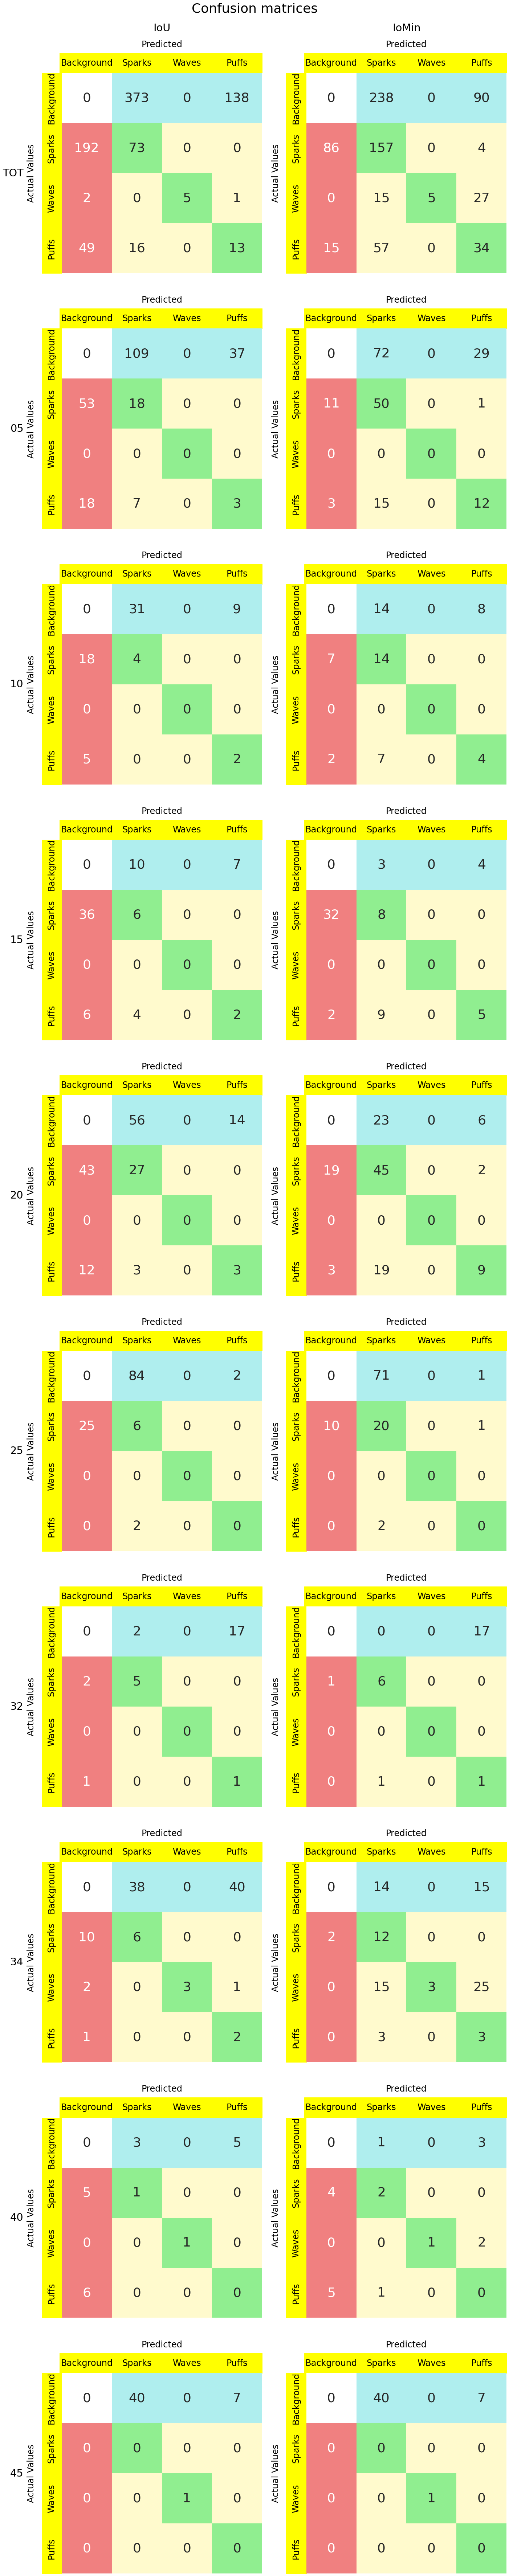

In [112]:
n_rows = (len(movie_ids)+1)#*2
n_cols = 2
num_plots = n_rows*n_cols

pad = 5 # in points

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 100))

cols = ['IoU', 'IoMin']
tick_labels = ['Background', 'Sparks', 'Waves', 'Puffs']

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1.2), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')



for ax, row in zip(axs[:,0], ['TOT']+movie_ids):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.suptitle("Confusion matrices", fontsize=36, y=1)
plt.rcParams.update({'font.size': 24})

# configure heatmap background
colors = sns.color_palette(['white',
                            'lightcoral',
                            'paleturquoise',
                            'lemonchiffon',
                            'lightgreen'], as_cmap=True)
colored_bg = [[0,2,2,2],
                [1,4,3,3],
                [1,3,4,3],
                [1,3,3,4]]

# Get array with confusion matrices to be plotted
cm_array = np.concatenate(([[iou_confusion_matrix_tot, iomin_confusion_matrix_tot]],
               [[iou_confusion_matrix[sample_id], iomin_confusion_matrix[sample_id]]
                for sample_id in movie_ids]), axis=0)

for row_id in range(n_rows):
    for col_id in range(n_cols):
        cm = cm_array[row_id, col_id].astype(int).astype(str)

        ax = axs[row_id, col_id]
        sns.heatmap(data=colored_bg, 
                    cmap=colors,
                    annot=cm,
                    fmt='', 
                    annot_kws={'fontsize': 36}, 
                    cbar=False, 
                    square=True,
                    ax = ax
                   )

        ax.tick_params(length=0, labeltop=True, labelbottom=False)
        ax.tick_params(axis='both', which='major', pad=16)

        ax.set_xlabel('Predicted', labelpad=32)
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(tick_labels)
        ax.add_patch(plt.Rectangle((-0.01, 1), 1.01, 0.1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))

        ax.set_ylabel('Actual Values', labelpad=32)
        ax.set_yticklabels(tick_labels, rotation=90, va='center')
        ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='yellow', clip_on=False, zorder=0, transform=ax.transAxes))

#plt.subplots_adjust(hspace=0.005, wspace=0.)
#plt.subplots_adjust(hspace=0.1, wspace=0.1, top=0.9, left=0.05, right=0.95)
#fig.subplots_adjust(left=0.15, top=0.95)
fig.subplots_adjust(wspace=1.5)
plt.tight_layout()
plt.savefig("all_confusion_matrices.png")
plt.show()